<a href="https://www.kaggle.com/code/peksyaji/regresi-dan-analisis-penyakit-jantung?scriptVersionId=91850991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regresi dan Analisis Penyakit Jantung

Ada 3 bagian yang akan kita kerjakan:
1. Membangun regresi logistik untuk memprediksi penyakit jantung berdasarkan dataset yang diberikan.
2. Menganalisis korelasi antara penyakit jantung, penyakit ginjal, diabetes, dan kanker kulit.
3. Memahami pengaruh Indeks Massa Tubuh (IMT/BMI) pada penyakit.

## 1. Membangun regresi logistik untuk memprediksi penyakit jantung berdasarkan dataset yang diberikan.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/personal-key-indicators-of-heart-disease/heart_2020_cleaned.csv


In [2]:
# Membaca file csv dan menampilkan 5 data teratas
df = pd.read_csv("/kaggle/input/personal-key-indicators-of-heart-disease/heart_2020_cleaned.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [4]:
# Cek data diabetes
df.Diabetic.value_counts()

No                         269653
Yes                         40802
No, borderline diabetes      6781
Yes (during pregnancy)       2559
Name: Diabetic, dtype: int64

In [5]:
# Karena kita ingin mendiagnosis sebagai 'Yes' untuk penyakit jantung, meskipun ada kemungkinan kecil, mari kita pertimbangkan 'No, borderline diabetes' dan 'Yes (during pregnancy)' sebagai 'No'.
df['Diabetic'] = df.Diabetic.apply(lambda x: 'No' if x == 'No, borderline diabetes' or x == 'Yes (during pregnancy)' else x)
df.Diabetic.value_counts()

No     278993
Yes     40802
Name: Diabetic, dtype: int64

In [6]:
# Cek data yang kosong
df.isnull().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

### Analisis data kategori

In [7]:
# Perhatikan bahwa kita memiliki beberapa variabel kategori dengan nilai Yes/No. Mari kita ubah ke biner 1/0
column_yesno = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

df[column_yesno] = df[column_yesno].apply(lambda x: x.map({'Yes':1,'No':0})) # Mengubah ke biner
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,Female,55-59,White,1,1,Very good,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,Female,80 or older,White,0,1,Very good,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,Male,65-69,White,1,1,Fair,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,Female,75-79,White,0,0,Good,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,Female,40-44,White,0,1,Very good,8.0,0,0,0


In [8]:
# Cek data
df.info()
heart_orig = df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  KidneyDisease     31

In [9]:
# Kita masih memiliki 4 variabel kategorik ('Yes'/'No'). Kita akan mengubahnya menjadi variabel dummy.
kategorik = df.select_dtypes(include=['object'])
kategorik.head()
cat_dummies = pd.get_dummies(kategorik, drop_first=True)
cat_dummies.head()
# Menghapus 4 variabel kategorik yang belum diubah.
df.drop(list(kategorik.columns), axis=1, inplace=True)
# Menambahkan variabel dummy ke data.
df = pd.concat([df, cat_dummies], axis=1)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,...,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,16.60,1,0,0,3.0,30.0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
2,0,26.58,1,0,0,20.0,30.0,0,1,1,...,0,0,0,0,0,1,1,0,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,23.71,0,0,0,28.0,0.0,1,0,1,...,0,0,0,0,0,1,0,0,0,1


In [10]:
# Di sini kita tertarik pada kemungkinan memiliki penyakit jantung berdasarkan variabel lain.
# Kolom 'HeartDisease' kita jadikan variabel dependen
y = df.pop('HeartDisease')
X = df
X.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,16.60,1,0,0,3.0,30.0,0,1,1,5.0,...,0,0,0,0,0,1,0,0,0,1
1,20.34,0,0,1,0.0,0.0,0,0,1,7.0,...,1,0,0,0,0,1,0,0,0,1
2,26.58,1,0,0,20.0,30.0,0,1,1,8.0,...,0,0,0,0,0,1,1,0,0,0
3,24.21,0,0,0,0.0,0.0,0,0,0,6.0,...,0,0,0,0,0,1,0,1,0,0
4,23.71,0,0,0,28.0,0.0,1,0,1,8.0,...,0,0,0,0,0,1,0,0,0,1


### Membagi data menjadi data latih dan data tes

In [11]:
# Membagi data menjadi data latih dan data tes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=100) # 75% data latih, 25% data tes
X_train.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Diabetic,PhysicalActivity,SleepTime,...,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
224032,30.23,0,0,0,3.0,30.0,0,0,1,7.0,...,0,0,0,1,0,0,0,1,0,0
68666,29.21,1,0,0,30.0,25.0,1,0,0,8.0,...,0,0,0,0,0,1,0,0,1,0
202671,24.03,0,0,0,10.0,3.0,0,0,1,7.0,...,0,0,0,0,0,1,0,0,0,0
301567,33.89,1,0,0,27.0,30.0,1,1,1,6.0,...,0,0,0,0,0,1,1,0,0,0
188559,20.18,0,0,0,5.0,0.0,0,0,1,8.0,...,0,0,0,0,0,1,0,1,0,0


In [12]:
len(X_train.columns) # cek banyak kolom data latih

35

In [13]:
# Skalakan variabel X
from sklearn.preprocessing import scale
# Menyekalakan variabel X latih
cols = X_train.columns
X_train = pd.DataFrame(scale(X_train))
X_train.columns = cols
# Menyekalakan variabel X tes
cols = X_test.columns
X_test = pd.DataFrame(scale(X_test))
X_test.columns = cols

In [14]:
# Mari kita gunakan RFE untuk memeriksa fitur yang diperlukan dan menghapus multikolearitas
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Menjalankan RFE dengan jumlah output variabel sama dengan 30
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=30)  # menjalankan RFE
rfe = rfe.fit(X_train, y_train)

In [15]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('BMI', True, 1),
 ('Smoking', True, 1),
 ('AlcoholDrinking', True, 1),
 ('Stroke', True, 1),
 ('PhysicalHealth', True, 1),
 ('MentalHealth', False, 2),
 ('DiffWalking', True, 1),
 ('Diabetic', True, 1),
 ('PhysicalActivity', False, 5),
 ('SleepTime', True, 1),
 ('Asthma', True, 1),
 ('KidneyDisease', True, 1),
 ('SkinCancer', True, 1),
 ('Sex_Male', True, 1),
 ('AgeCategory_25-29', True, 1),
 ('AgeCategory_30-34', True, 1),
 ('AgeCategory_35-39', True, 1),
 ('AgeCategory_40-44', True, 1),
 ('AgeCategory_45-49', False, 4),
 ('AgeCategory_50-54', True, 1),
 ('AgeCategory_55-59', True, 1),
 ('AgeCategory_60-64', True, 1),
 ('AgeCategory_65-69', True, 1),
 ('AgeCategory_70-74', True, 1),
 ('AgeCategory_75-79', True, 1),
 ('AgeCategory_80 or older', True, 1),
 ('Race_Asian', True, 1),
 ('Race_Black', True, 1),
 ('Race_Hispanic', True, 1),
 ('Race_Other', False, 3),
 ('Race_White', False, 6),
 ('GenHealth_Fair', True, 1),
 ('GenHealth_Good', True, 1),
 ('GenHealth_Poor', True, 1),
 ('GenHe

In [16]:
rfe_columns = X_train.columns[rfe.support_]
rfe_columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Sex_Male', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')

In [17]:
# Membuat dataframe X_train dengan variabel hasil pemilihan dari RFE
X_train_rfe = X_train[rfe_columns]
X_train_rfe.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,DiffWalking,Diabetic,SleepTime,Asthma,KidneyDisease,...,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0.300831,-0.837466,-0.270002,-0.19728,-0.046510,-0.401575,-0.381753,-0.068073,-0.393791,-0.195287,...,-0.327164,-0.268354,-0.285948,-0.161653,-0.277865,3.267136,-0.348251,1.559915,-0.191529,-0.743582
1,0.140104,1.194078,-0.270002,-0.19728,3.349456,2.490195,-0.381753,0.628743,2.539416,-0.195287,...,-0.327164,-0.268354,-0.285948,-0.161653,-0.277865,-0.306078,-0.348251,-0.641060,5.221149,-0.743582
2,-0.676135,-0.837466,-0.270002,-0.19728,0.833926,-0.401575,-0.381753,-0.068073,-0.393791,-0.195287,...,-0.327164,-0.268354,-0.285948,-0.161653,-0.277865,-0.306078,-0.348251,-0.641060,-0.191529,-0.743582
3,0.877556,1.194078,-0.270002,-0.19728,2.972126,2.490195,2.619493,-0.764890,-0.393791,-0.195287,...,-0.327164,3.726415,-0.285948,-0.161653,-0.277865,-0.306078,2.871493,-0.641060,-0.191529,-0.743582
4,-1.282800,-0.837466,-0.270002,-0.19728,0.205043,-0.401575,-0.381753,0.628743,-0.393791,-0.195287,...,-0.327164,-0.268354,-0.285948,-0.161653,-0.277865,-0.306078,-0.348251,1.559915,-0.191529,-0.743582


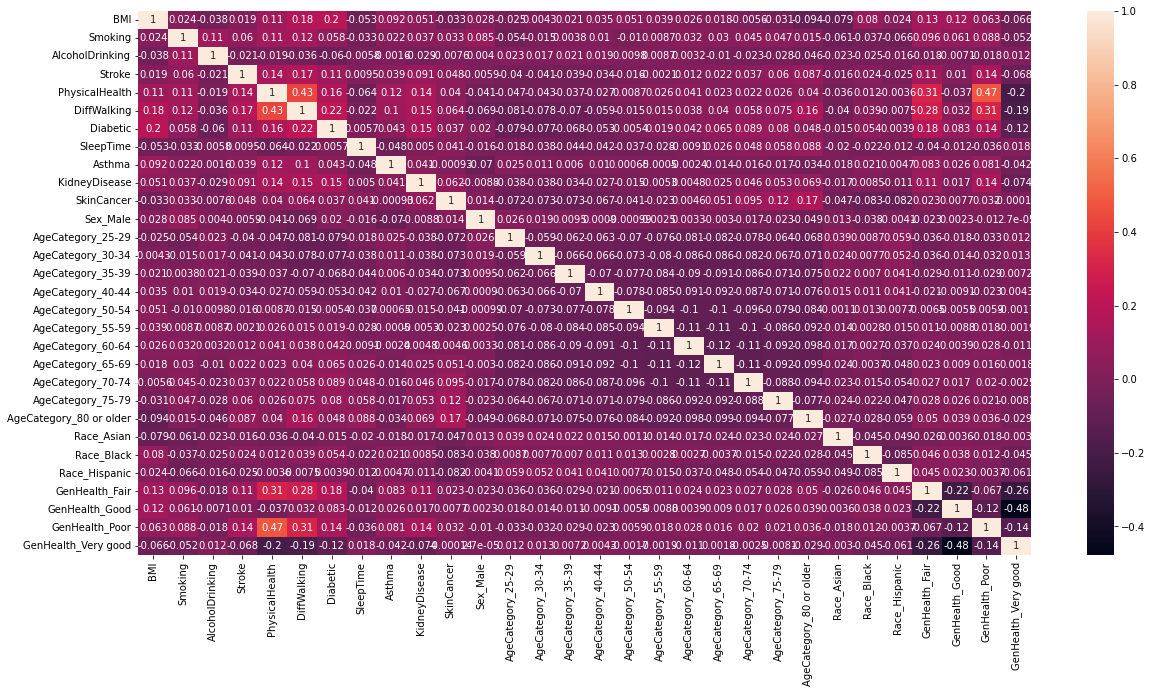

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,10))
sns.heatmap(X_train_rfe.corr(),annot = True)
plt.show()

In [19]:
# Membangun model linier dengan statsmodel

import statsmodels.api as sm  
logm1 = sm.GLM(list(y_train),(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               239846
Model:                            GLM   Df Residuals:                   239815
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54341.
Date:                Fri, 01 Apr 2022   Deviance:                   1.0868e+05
Time:                        14:59:11   Pearson chi2:                 2.22e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1217
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.1532      0.013   -234.133      0.000      -3.180      -3.127
BMI                         0.0613      0.008      7.354      0.000       0.045       0.078
Smoking                     0.1899      0.008     23.255      0.000       0.174       0.206
AlcoholDrinking            -0.0564      0.010     -5.781      0.000      -0.076      -0.037
Stroke                      0.2018      0.005     40.396      0.000       0.192       0.212
PhysicalHealth              0.0243      0.008      3.108      0.002       0.009       0.040
DiffWalking                 0.0726      0.007     10.106      0.000       0.058       0.087
Diabetic                    0.1601      0.006     25.049      0.000       0.148       0.173
SleepTime                  -0.0520      0.007     -7.188      0.000      -0.066      -0.038
Asthma                      0.0906      0.008     11.935      0.000       0.076       0.105
KidneyDisease               0.1072      0.005     20.178      0.000       0.097       0.118
SkinCancer                  0.0328      0.007      5.003      0.000       0.020       0.046
Sex_Male                    0.3464      0.008     41.521      0.000       0.330       0.363
AgeCategory_25-29          -0.2052      0.025     -8.210      0.000      -0.254      -0.156
AgeCategory_30-34          -0.1204      0.021     -5.809      0.000      -0.161      -0.080
AgeCategory_35-39          -0.1029      0.020     -5.258      0.000      -0.141      -0.065
AgeCategory_40-44          -0.0051      0.017     -0.305      0.761      -0.038       0.028
AgeCategory_50-54           0.2023      0.014     14.410      0.000       0.175       0.230
AgeCategory_55-59           0.2774      0.014     19.697      0.000       0.250       0.305
AgeCategory_60-64           0.3777      0.014     26.669      0.000       0.350       0.405
AgeCategory_65-69           0.4512      0.014     32.269      0.000       0.424       0.479
AgeCategory_70-74           0.5181      0.013     38.845      0.000       0.492       0.544
AgeCategory_75-79           0.4877      0.012     41.923      0.000       0.465       0.511
AgeCategory_80 or older     0.5829      0.012     48.063      0.000       0.559       0.607
Race_Asian                 -0.0703      0.012     -5.802      0.000      -0.094      -0.047
Race_Black                 -0.0777      0.009     -8.949      0.000      -0.095      -0.061
Race_Hispanic              -0.0543      0.010     -5.425      0.000      -0.074      -0.035
GenHealth_Fair              0.4823      0.012     41.144      0.000       0.459       0.505
GenHealth_Good              0.4759      0.016     30.694      0.000       0.445       0.506
GenHealth_Poor              0.3559      0.009     41.070      0.000       0.339       0.373
GenHealth_Very good         0.2260      0.017  

In [20]:
X_train_rfe = X_train_rfe.drop(['AgeCategory_40-44'], axis=1) # Membuang variabel 'AgeCategory_40-44' karena P>|z|=0,761>0,05
X_train_rfe.columns

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'DiffWalking', 'Diabetic', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer', 'Sex_Male', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_50-54', 'AgeCategory_55-59',
       'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74',
       'AgeCategory_75-79', 'AgeCategory_80 or older', 'Race_Asian',
       'Race_Black', 'Race_Hispanic', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good'],
      dtype='object')

In [21]:
# Membangun model linier dengan statsmodel

import statsmodels.api as sm  
logm1 = sm.GLM(list(y_train),(sm.add_constant(X_train_rfe)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               239846
Model:                            GLM   Df Residuals:                   239816
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -54341.
Date:                Fri, 01 Apr 2022   Deviance:                   1.0868e+05
Time:                        14:59:15   Pearson chi2:                 2.22e+05
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1217
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.1533      0.013   -234.144      0.000      -3.180      -3.127
BMI                         0.0612      0.008      7.349      0.000       0.045       0.078
Smoking                     0.1898      0.008     23.258      0.000       0.174       0.206
AlcoholDrinking            -0.0564      0.010     -5.782      0.000      -0.076      -0.037
Stroke                      0.2018      0.005     40.397      0.000       0.192       0.212
PhysicalHealth              0.0243      0.008      3.107      0.002       0.009       0.040
DiffWalking                 0.0726      0.007     10.108      0.000       0.059       0.087
Diabetic                    0.1601      0.006     25.051      0.000       0.148       0.173
SleepTime                  -0.0520      0.007     -7.185      0.000      -0.066      -0.038
Asthma                      0.0906      0.008     11.937      0.000       0.076       0.105
KidneyDisease               0.1072      0.005     20.177      0.000       0.097       0.118
SkinCancer                  0.0328      0.007      5.003      0.000       0.020       0.046
Sex_Male                    0.3465      0.008     41.526      0.000       0.330       0.363
AgeCategory_25-29          -0.2036      0.024     -8.332      0.000      -0.251      -0.156
AgeCategory_30-34          -0.1187      0.020     -5.943      0.000      -0.158      -0.080
AgeCategory_35-39          -0.1011      0.019     -5.410      0.000      -0.138      -0.064
AgeCategory_50-54           0.2043      0.013     16.328      0.000       0.180       0.229
AgeCategory_55-59           0.2795      0.012     22.713      0.000       0.255       0.304
AgeCategory_60-64           0.3799      0.012     31.205      0.000       0.356       0.404
AgeCategory_65-69           0.4535      0.012     37.923      0.000       0.430       0.477
AgeCategory_70-74           0.5203      0.011     45.696      0.000       0.498       0.543
AgeCategory_75-79           0.4895      0.010     48.763      0.000       0.470       0.509
AgeCategory_80 or older     0.5848      0.010     56.052      0.000       0.564       0.605
Race_Asian                 -0.0703      0.012     -5.801      0.000      -0.094      -0.047
Race_Black                 -0.0777      0.009     -8.949      0.000      -0.095      -0.061
Race_Hispanic              -0.0543      0.010     -5.425      0.000      -0.074      -0.035
GenHealth_Fair              0.4823      0.012     41.144      0.000       0.459       0.505
GenHealth_Good              0.4759      0.016     30.693      0.000       0.445       0.506
GenHealth_Poor              0.3559      0.009     41.070      0.000       0.339       0.373
GenHealth_Very good         0.2260      0.017     13.453      0.000       0.193       0.259
===============================================

In [22]:
# Cek nilai variance_inflation_factor (VIF) dari variabel fitur

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()

vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
26,GenHealth_Good,1.88
25,GenHealth_Fair,1.80
28,GenHealth_Very good,1.78
27,GenHealth_Poor,1.68
4,PhysicalHealth,1.63
21,AgeCategory_80 or older,1.46
5,DiffWalking,1.44
19,AgeCategory_70-74,1.44
18,AgeCategory_65-69,1.44
17,AgeCategory_60-64,1.41


### Analisis residual pada data latih

In [23]:
lm.fit(X_train_rfe, y_train)
y_train_pred = lm.predict(X_train_rfe)
y_train_pred

array([-0.01414568,  0.32616801, -0.02176538, ...,  0.00642306,
        0.02833513, -0.03409062])

In [24]:
y_train_pred_final = pd.DataFrame({'Actual':y_train, 'HeartDisease_Prob':y_train_pred})
y_train_pred_final.head()

,Actual,HeartDisease_Prob
224032,0,-0.014146
68666,1,0.326168
202671,0,-0.021765
301567,1,0.317204
188559,0,0.056525


In [25]:
# Membuat kolom dengan batas probabilitas yang berbeda
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.HeartDisease_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Actual,HeartDisease_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
224032,0,-0.014146,0,0,0,0,0,0,0,0,0,0
68666,1,0.326168,1,1,1,1,0,0,0,0,0,0
202671,0,-0.021765,0,0,0,0,0,0,0,0,0,0
301567,1,0.317204,1,1,1,1,0,0,0,0,0,0
188559,0,0.056525,1,0,0,0,0,0,0,0,0,0


In [26]:
# Menghitung akurasi sensitivitas dan spesifisitas untuk berbagai kemungkinan cutoff.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives
from sklearn import metrics

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Actual, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.277119  0.985771  0.211062
0.1   0.1  0.706695  0.822111  0.695937
0.2   0.2  0.864738  0.496944  0.899022
0.3   0.3  0.907299  0.259645  0.967670
0.4   0.4  0.915788  0.109286  0.990966
0.5   0.5  0.915767  0.034717  0.997894
0.6   0.6  0.915191  0.008019  0.999754
0.7   0.7  0.914795  0.000831  0.999991
0.8   0.8  0.914733  0.000000  1.000000
0.9   0.9  0.914733  0.000000  1.000000


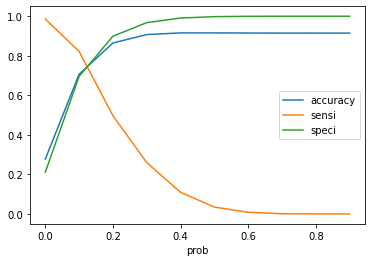

In [27]:
# 0.2 menjadi cutoff yang baik untuk kasus ini karena tidak terjadi perubahan akurasi yang tinggi saat 0,2 dst.
# Plot sensitivitas akurasi dan spesifisitas untuk berbagai probabilitas.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

### Menguji model dan memprediksi y_test

In [28]:
cutoff = 0.2
y_train_pred_final['final_pred'] = y_train_pred_final.HeartDisease_Prob.apply(lambda x: 1 if x>cutoff else 0)
y_train_pred_final.head()

,Actual,HeartDisease_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_pred
224032,0,-0.014146,0,0,0,0,0,0,0,0,0,0,0
68666,1,0.326168,1,1,1,1,0,0,0,0,0,0,1
202671,0,-0.021765,0,0,0,0,0,0,0,0,0,0,0
301567,1,0.317204,1,1,1,1,0,0,0,0,0,0,1
188559,0,0.056525,1,0,0,0,0,0,0,0,0,0,0


## Kita lakukan prediksi pada data test

In [29]:
# Menambahkan variabel konstan
X_test_new = X_test[rfe_columns]
X_test_new.drop(['AgeCategory_40-44'], axis=1, inplace=True)
X_test_new.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,DiffWalking,Diabetic,SleepTime,Asthma,KidneyDisease,...,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,Race_Asian,Race_Black,Race_Hispanic,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,-0.615274,-0.839165,-0.27127,-0.200305,-0.424761,-0.401588,-0.384429,-0.066186,-0.39249,-0.196354,...,-0.330549,-0.268336,-0.285461,-0.15853,-0.278326,-0.307363,-0.350226,-0.640767,-0.190579,-0.743485
1,2.429016,-0.839165,-0.27127,-0.200305,-0.424761,-0.401588,-0.384429,-0.761247,-0.39249,-0.196354,...,-0.330549,-0.268336,-0.285461,-0.15853,-0.278326,3.253480,-0.350226,-0.640767,-0.190579,1.345017
2,-0.270756,-0.839165,-0.27127,-0.200305,-0.424761,-0.401588,-0.384429,-0.761247,-0.39249,-0.196354,...,-0.330549,-0.268336,-0.285461,-0.15853,-0.278326,-0.307363,-0.350226,-0.640767,-0.190579,1.345017
3,-0.798496,-0.839165,-0.27127,-0.200305,-0.424761,-0.401588,-0.384429,0.628875,-0.39249,-0.196354,...,-0.330549,-0.268336,-0.285461,-0.15853,-0.278326,3.253480,-0.350226,1.560629,-0.190579,-0.743485
4,-0.087535,1.191661,-0.27127,-0.200305,-0.424761,-0.401588,-0.384429,0.628875,-0.39249,-0.196354,...,-0.330549,-0.268336,-0.285461,-0.15853,-0.278326,-0.307363,-0.350226,-0.640767,-0.190579,-0.743485


In [30]:
# Membuat prediksi
y_test_pred = lm.predict(X_test_new)
y_test_pred[:10]

array([ 0.00078405, -0.04617346, -0.01012691, -0.01825   ,  0.02424266,
        0.06136343, -0.04574852, -0.0147961 , -0.03220185,  0.01814052])

In [31]:
# Mengubah y_pred menjadi dataframe
y_pred_df = pd.DataFrame(y_test_pred)
y_pred_df.head()
# Mengubah y_test menjadi dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,HeartDisease
290281,0
65173,0
58744,0
207715,0
168868,0


In [32]:
# Menghapus indeks untuk kedua dataframe untuk menambahkannya secara berdampingan
y_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [33]:
# Menambahkan y_test_df dan y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_df],axis=1)
y_pred_final.head()

,HeartDisease,0
0,0,0.000784
1,0,-0.046173
2,0,-0.010127
3,0,-0.018250
4,0,0.024243


In [34]:
# Mengubah nama kolom
y_pred_final = y_pred_final.rename(columns={0: 'HeartDidease_Prob'})
y_pred_final.head()

,HeartDisease,HeartDidease_Prob
0,0,0.000784
1,0,-0.046173
2,0,-0.010127
3,0,-0.018250
4,0,0.024243


In [35]:
# Tetapkan prediksi akhir berdasarkan cutoff 0,2
y_pred_final['final_prediction'] = y_pred_final['HeartDidease_Prob'].apply(lambda x: 1 if x>cutoff else 0)
y_pred_final.head()

,HeartDisease,HeartDidease_Prob,final_prediction
0,0,0.000784,0
1,0,-0.046173,0
2,0,-0.010127,0
3,0,-0.018250,0
4,0,0.024243,0


In [36]:
confusion = metrics.confusion_matrix(y_pred_final.HeartDisease, y_pred_final.final_prediction )
confusion

array([[65711,  7316],
       [ 3502,  3420]])

In [37]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [38]:
# Melihat sensitifitas model logistik yang kita bangun
TP / float(TP+FN)

0.4940768563998844

In [39]:
# Hitung spesifisitasnya
TN / float(TN+FP)

0.8998178755802648

In [40]:
# Akurasi
(TP+TN)/(TP+TN+FP+FN)

0.8646887390711578

## Kesimpulan

### Model tampaknya memiliki sensitivitas dan spesifisitas yang layak. Oleh karena itu model ini tampaknya dapat digunakan.

* Sensitivitasnya adalah 49,4%
* Specifisitasnya adalah 89,98%
* Akurasinya 86,46%

## 2. Menganalisis korelasi antara berbagai penyakit

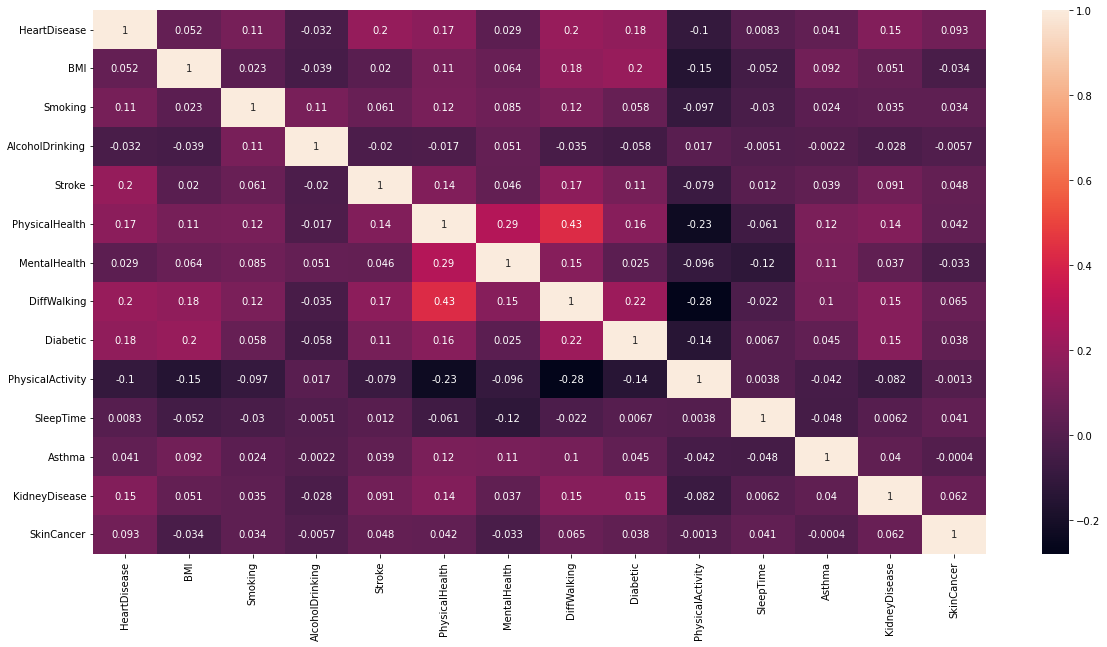

In [41]:
# Cek heat map data awal
plt.figure(figsize = (20,10))
sns.heatmap(heart_orig.corr(),annot = True)
plt.show()

In [42]:
# Pertimbangkan hanya fitur penyakitnya
penyakit = heart_orig[['HeartDisease', 'Stroke', 'Diabetic', 'KidneyDisease', 'SkinCancer']]
penyakit.head()

,HeartDisease,Stroke,Diabetic,KidneyDisease,SkinCancer
0,0,0,1,0,1
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,0,1
4,0,0,0,0,0


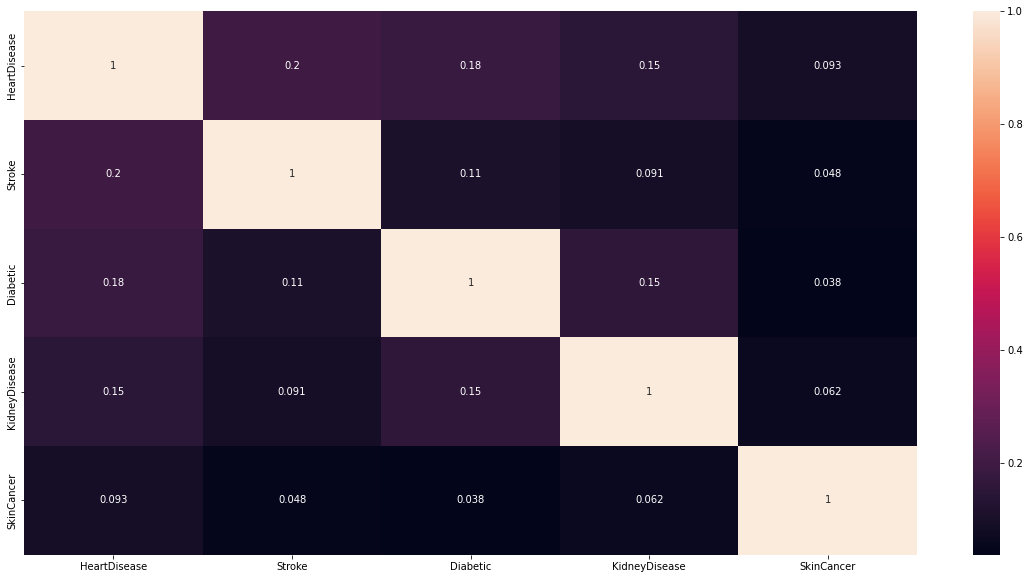

In [43]:
# Cek heat map
plt.figure(figsize = (20,10))
sns.heatmap(penyakit.corr(),annot = True)
plt.show()

### Observasi
* Heart disease dan stroke berkorelasi
* Diabetes berkorelasi dengan heart disease dan Kidney disease. Lebih rendah dari Stroke.
* Skin cancer tidak berkorelasi dengan ke-4 penyakit lainnya.

In [44]:
# Mari kita pahami jika diabetes mempengaruhi penyakit jantung.
diabetics = heart_orig[heart_orig.Diabetic==1]
heart_d = sum(diabetics.HeartDisease)/len(diabetics)
print("Peluang orang yang terkena diabetes juga terkena penyakit jantung adalah")
print(heart_d)

heart_patients = heart_orig[heart_orig.HeartDisease==1]
diabs = sum(heart_patients.Diabetic)/len(heart_patients)
print("Peluang orang yang terkena penyakit jantung juga terkena diabetes adalah")
print(diabs)


Peluang orang yang terkena diabetes juga terkena penyakit jantung adalah
0.21952355276702123
Peluang orang yang terkena penyakit jantung juga terkena diabetes adalah
0.3272202535345048


In [45]:
# Mari kita pahami jika diabetes mempengaruhi penyakit ginjal.
diabeticsk = heart_orig[heart_orig.Diabetic==1]
kidney_d = sum(diabeticsk.KidneyDisease)/len(diabeticsk)
print("Peluang orang yang terkena diabetes juga terkena penyakit ginjal adalah")
print(kidney_d)

kidney_patients = heart_orig[heart_orig.KidneyDisease==1]
diabsk = sum(kidney_patients.Diabetic)/len(kidney_patients)
print("Peluang orang yang terkena penyakit ginjal juga terkena diabetes adalah")
print(diabsk)

Peluang orang yang terkena diabetes juga terkena penyakit ginjal adalah
0.11281309739718641
Peluang orang yang terkena penyakit ginjal juga terkena diabetes adalah
0.39078020205450376


Penyakit ginjal bahkan lebih dipengaruhi oleh diabetes. Hampir 40% menderita diabetes. Hal ini tentunya menunjukkan bahwa diabetes memiliki peran dalam penyakit ginjal.

## 3. Memahami pengaruh BMI pada penyakit.

In [46]:
diseases_bmi = heart_orig[['HeartDisease', 'Stroke', 'Diabetic', 'KidneyDisease', 'SkinCancer', 'BMI']]
diseases_bmi.head()

,HeartDisease,Stroke,Diabetic,KidneyDisease,SkinCancer,BMI
0,0,0,1,0,1,16.60
1,0,1,0,0,0,20.34
2,0,0,1,0,0,26.58
3,0,0,0,0,1,24.21
4,0,0,0,0,0,23.71


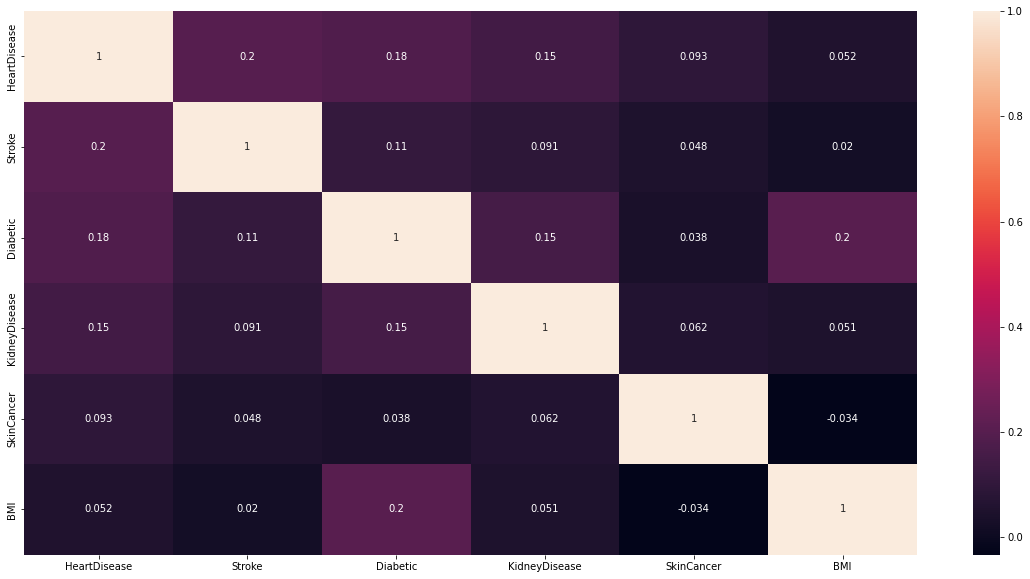

In [47]:
plt.figure(figsize=(20,10))
sns.heatmap(diseases_bmi.corr(), annot=True)
plt.show()

Ada beberapa petunjuk di sini karena korelasi antara BMI dan Diabetes. Diabetes pada gilirannya menyebabkan penyakit jantung dan penyakit ginjal seperti yang kita pelajari dalam analisis sebelumnya.

## Cek BMI > 24

In [48]:
diseases_bmi['BMI24'] = diseases_bmi['BMI'].apply(lambda x: 1 if x>24 else 0)
diseases_bmi.head()

,HeartDisease,Stroke,Diabetic,KidneyDisease,SkinCancer,BMI,BMI24
0,0,0,1,0,1,16.60,0
1,0,1,0,0,0,20.34,0
2,0,0,1,0,0,26.58,1
3,0,0,0,0,1,24.21,1
4,0,0,0,0,0,23.71,0


In [49]:
bmi_24 = diseases_bmi[diseases_bmi.BMI24==1]
bmi_diabetic = sum(bmi_24.Diabetic)/len(bmi_24)
print('peluang orang dengan BMI tinggi terkena diabetes adalah')
print(bmi_diabetic)

diabetes = diseases_bmi[diseases_bmi.Diabetic==1]
diab_bmi = sum(diabetes.BMI24)/len(diabetes)
print('peluang orang diabetes yang juga BMI>24 adalah')
print(diab_bmi)

peluang orang dengan BMI tinggi terkena diabetes adalah
0.15251197416659384
peluang orang diabetes yang juga BMI>24 adalah
0.898240282339101
